<a id="Haut"></a>
## Commencer a jouer 😈 
1. [Import packages](#Import)
1. [Preprocess functions](#Preprocess)
1. [Setting parameters](#Parameters)
1. [Créer Deep Q-Learning Neural Network](#QLNN)

---

In [1]:
import sys

In [2]:
#sys.executable

In [3]:
#sys.path
#Check Readme.md for detail sys.path.append(/users/....../bin/python3/jwojfoi )

In [4]:
import tensorflow as tf
import numpy as np
from vizdoom import *

import random
import time
from skimage import transform

from collections import deque
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [5]:
# On Créer la env
def creer_env():
    game = DoomGame()
    
    # Lire the setting et Initial
    game.load_config('/Users/johnny_hung/.ja_reinforecement_learning_lab/lib/python3.6/site-packages/vizdoom/scenarios/basic.cfg')
    game.set_doom_scenario_path('/Users/johnny_hung/.ja_reinforecement_learning_lab/lib/python3.6/site-packages/vizdoom/scenarios/basic.wad')
    game.init()
    
    # Les actions
    left  = [1,0,0]
    right = [0,1,0]
    shoot = [0,0,1]
    possible_actions = [left,right,shoot]
    
    return game, possible_actions

def test_env():
    game = DoomGame()
    
    # Lire the setting et Initial
    game.load_config('/Users/johnny_hung/.ja_reinforecement_learning_lab/lib/python3.6/site-packages/vizdoom/scenarios/basic.cfg')
    game.set_doom_scenario_path('/Users/johnny_hung/.ja_reinforecement_learning_lab/lib/python3.6/site-packages/vizdoom/scenarios/basic.wad')
    game.init()
    
    # Les actions
    left  = [1,0,0]
    right = [0,1,0]
    shoot = [0,0,1]
    possible_actions = [left,right,shoot]
    
    episodes = 3
    for i in range(episodes):
        print("Start new episode !!!!!!!!!!!!!!!!!!!!!!!!!!!")
        game.new_episode()
        while not game.is_episode_finished():
            state  = game.get_state()
            img    = state.screen_buffer
            misc   = state.game_variables
            action = random.choice(possible_actions)
            print("action = ",action)
            reward = game.make_action(action)
            print("         reward:", reward)
            time.sleep(0.02)
        print("Result: ",game.get_total_reward())
        time.sleep(2)
    game.close()
    

<a id="Preprocess"></a>
### Créer les preprocessing functions  🔧
- ___preprocess_frame(frame)___
- __stack_frames(stacked_frames,state,is_new_episode)__
---

In [6]:
game, possible_actions = creer_env()

In [7]:
def preprocess_frame(frame):
    # Remove the root (useless information)
    cropped_frame = frame[40:-10,30:-30] #Johnny tune tune tune les parameters
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    # Resize
    preprocessed_frame = transform.resize(normalized_frame,[84,84])
    return preprocessed_frame

In [8]:
frame_stack_size = 4

# On contrler la size de deque pour 4 tout les temps
stacked_frames = deque( [np.zeros((84,84), dtype=np.int) for i in range(frame_stack_size)], maxlen=4)
def stack_frames(stacked_frames, state, is_new_episode):
    # preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Re-initial le stacked_frames
        stacked_frames = deque( [np.zeros((84,84), dtype=np.int) for i in range(frame_stack_size)], maxlen=4)
        
        # On fais 4x en premier dans tout le nouvelle episode
        for _ in range(4):
            stacked_frames.append(frame)
        
        # package la frame
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, 
        stacked_frames.append(frame)
        
        # Build the stacked state  (84,84,4)
        stacked_state = np.stack(stacked_frames, axis=2)
    
    return stacked_state, stacked_frames

<a id="Parameters"></a>
### Créer les parameters
---

In [9]:
################################## Model et Training #################################
state_size     = [84,84,4]  #Notre input, c'est 4 stack (Width,Height, Channels)
action_size    = game.get_available_buttons_size()  # Trois possible actions
learning_rate  = 0.0002
total_episodes = 500
max_steps      = 100   #Max steps in one episode
batch_size     = 64

###########################  Exploration , Epsilon #############################
explore_start  = 1.0
explore_step   = 0.01
decay_rate     = 0.0001
gamma          = 0.95    #Qlearning


###############################  Memory     ###############################
pretrain_length = batch_size
memory_size     = 1000000

# True for training, False for watching the agent play
training       = True
# True for Render the env 
episode_render = False

<a id="QLNN"></a>
### Créer Deep Q-Learning Neural Network
---
1. stacked_state     (84,84,  4) 
1. Convolution layer (20,20, 32) > ELU
1. Convolution layer ( 9, 9, 64) > ELU
1. Convolution layer ( 3, 3,128) > ELU
1. Flaterten   layer 
1. FC                (512 units) > ELU
1. FC                (  3 units) Q-Value=(Left,Right,Shoot)


In [ ]:
class Mon_DQNN:
    def __init__(self,state_size,action_size,learning_rate,norm="Mon_DQNN"):
        self.state_size    = state_size
        self.action_size   = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(norm):
            
            """ 1. Stacked_State(84,84,4)"""
            # Créer la inputs comme ça [None, 84, 84, 4]
            self.inputs_   = tf.placeholder(tf.float32, [None, *state_size], name="inputs_")
            self.actions_  = tf.placeholder(tf.float32, [None,           3], name="actions_")
            
            # Ne oubilier pas que Target_Q = R(s,a) + ymax Q at (s',a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """ 2. Convolution layer(20,20,32)
                   Note: new_width = (84-8+1) / 4 = 77/4 = 19.25 ->(padding=VALID) 20
            """
            self.conv1           = tf.layers.conv2d(   inputs             = self.inputs_,
                                                       filters            = 32,
                                                       kernel_size        = [8,8],
                                                       strides            = [4,4],
                                                       padding            = "VALID",
                                                       kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                                       name               = "conv1")
            
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                                 training = True,
                                                                 epsilon  = 1e-5,
                                                                 name     = "batch_norm1")
            
            # I try to use famout relu first.
            self.conv1_out        = tf.nn.elu(self.conv1_batchnorm, name  = "conv1_out")
            #self.conv1_out       = tf.nn.relu(self.conv1_batchnorm, name  = "conv1_out")
            
            """ 3. Convolution layer( 9, 9, 64) """
            self.conv2 = tf.layers.conv2d( inputs             = self.conv1_out,
                                           filters            = 64,
                                           kernel_size        = [4,4],
                                           strides            = [2,2],
                                           padding            = "VALID",
                                           kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                           name               = "conv2")
            
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                                 training = True,
                                                                 epsilon  = 1e-5,
                                                                 name     = "batch_norm2")
            
            # I try to use famout relu first.
            self.conv2_out        = tf.nn.elu(self.conv2_batchnorm, name  = "conv2_out")
            #self.conv1_out       = tf.nn.relu(self.conv1_batchnorm, name  = "conv2_out")
            
            """ 4. Convolution layer( 3, 3, 128) """
            self.conv3 = tf.layers.conv2d( inputs             = self.conv2_out,
                                           filters            = 128,
                                           kernel_size        = [4,4],
                                           strides            = [2,2],
                                           padding            = "VALID",
                                           kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                           name               = "conv3")
            
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                                 training = True,
                                                                 epsilon  = 1e-5,
                                                                 name     = "batch_norm3")
            
            # I try to use famout relu first.
            self.conv3_out        = tf.nn.elu(self.conv3_batchnorm, name  = "conv3_out")
            #self.conv1_out       = tf.nn.relu(self.conv1_batchnorm, name  = "conv2_out")
            
            
            """ 5. Flatten layer  """
            self.flatten = tf.layers.flatten(self.conv3_out)
            
            
            """ 6. FC Layer"""
            self.fc      = tf.layers.dense( inputs            = self.flatten,
                                            units             = 512,
                                            activation        = tt.nn.elu,
                                            kernel_initializer= tf.contrib.layers.xavier_initializer(),
                                            name              = "fc1")
            
            self.output  = tf.layers.dense( inputs            = self.fc,
                                            units             = 3,
                                            activation        = None)
            
            # Q is our predicted Qvlaue.
            self.Q = 
            

<a id="referenced"></a>
## 99 Referenced 📚
---
1. [TestEnv](#Testenv)
1. [Frame](#Frame)
1. [Stack](#Stack)
---
Note:
1. [Padding with Valid](#Padding)
---

<a id="Testenv"></a>
### Running the following code, to check your env is setting ok or not
---

In [10]:
test_env()

Start new episode !!!!!!!!!!!!!!!!!!!!!!!!!!!
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: 100.0
action =  [1, 0, 0]
         reward: -1.0
Result:  94.0
Start new episode !!!!!!!!!!!!!!!!!!!!!!!!!!!
action =  [1, 0, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -6.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [

action =  [0, 0, 1]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -6.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -1.0
action =  [0, 1, 0]
         reward: -6.0
action =  [0, 1, 0]
         reward: -1.0
action =  [1, 0, 0]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 0, 1]
         reward: -1.0
action =  [0, 0, 1]
         rewar

<a id="Frame"></a> 
### C'est quoi: Frame 🤔
---
C'est important pour comprendre <font color="green"> la frame = le state </font> parceque, AI regard tout le state pour jouer , comme nous, par la écran. 

La ___vizdoom env___ faire créer la frame plus gros(avec toit d'un stage, enemy, etc..). Mais, on n'a besoin pas de "toit" pour traning. Ainsi, on change la size à (84,84). C'est mieux pour nous en training. 

In [11]:
# Obtenir test env.
game_test, possible_actions = creer_env()
state_frame = game_test.get_state().screen_buffer
state_frame

array([[[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 39, 39, ..., 39, 39, 39],
        [59, 67, 59, ..., 67, 67, 91],
        [79, 79, 79, ..., 79, 91, 91],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], dtype=uint8)

In [12]:
state_frame.shape

(3, 240, 320)

In [13]:
normalized_frame = state_frame / 255.0
normalized_frame

array([[[0.1372549 , 0.15294118, 0.15294118, ..., 0.15294118,
         0.15294118, 0.15294118],
        [0.23137255, 0.2627451 , 0.23137255, ..., 0.2627451 ,
         0.2627451 , 0.35686275],
        [0.30980392, 0.30980392, 0.30980392, ..., 0.30980392,
         0.35686275, 0.35686275],
        ...,
        [0.0745098 , 0.0745098 , 0.04313725, ..., 0.18431373,
         0.18431373, 0.21568627],
        [0.0745098 , 0.10588235, 0.0745098 , ..., 0.18431373,
         0.18431373, 0.18431373],
        [0.04313725, 0.0745098 , 0.0745098 , ..., 0.10588235,
         0.0745098 , 0.0745098 ]],

       [[0.1372549 , 0.15294118, 0.15294118, ..., 0.15294118,
         0.15294118, 0.15294118],
        [0.23137255, 0.2627451 , 0.23137255, ..., 0.2627451 ,
         0.2627451 , 0.35686275],
        [0.30980392, 0.30980392, 0.30980392, ..., 0.30980392,
         0.35686275, 0.35686275],
        ...,
        [0.0745098 , 0.0745098 , 0.04313725, ..., 0.18431373,
         0.18431373, 0.21568627],
        [0.0

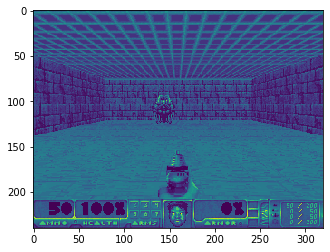

In [14]:
# Affichier one by one: [0] ou [1] ou [2] 
plt.imshow(normalized_frame[2])
plt.show()

Lib referenced: [np.mean](http://lagrange.univ-lyon1.fr/docs/numpy/1.11.0/reference/generated/numpy.mean.html) 🐣

In [15]:
# Réduire la couvrir à une piece selument
reduced_frame = np.mean(normalized_frame,axis=0)
reduced_frame.shape #(240, 320)

(240, 320)

In [16]:
reduced_frame

array([[0.1372549 , 0.15294118, 0.15294118, ..., 0.15294118, 0.15294118,
        0.15294118],
       [0.23137255, 0.2627451 , 0.23137255, ..., 0.2627451 , 0.2627451 ,
        0.35686275],
       [0.30980392, 0.30980392, 0.30980392, ..., 0.30980392, 0.35686275,
        0.35686275],
       ...,
       [0.0745098 , 0.0745098 , 0.04313725, ..., 0.18431373, 0.18431373,
        0.21568627],
       [0.0745098 , 0.10588235, 0.0745098 , ..., 0.18431373, 0.18431373,
        0.18431373],
       [0.04313725, 0.0745098 , 0.0745098 , ..., 0.10588235, 0.0745098 ,
        0.0745098 ]])

In [17]:
# Réduire la toit
# C'est important:  [ y-direction, x-direction ]
cut_frame = reduced_frame[40:-10,30:-30]
cut_frame.shape  #(200,260)

(190, 260)

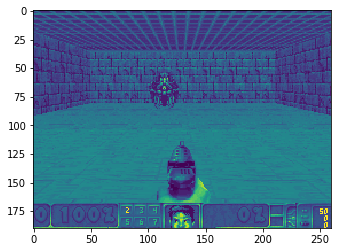

In [18]:
plt.imshow(cut_frame)
plt.show()

<a id="Stack"></a>
### Explique pour le np.stack(stacked_frames, axis=2)
1. deque method: C'est FIFO (First in , First out)
1. On fixed le maxlen = 4, continuer changer la frame 
---

In [19]:
input_stack_size = 4
stacked_frames = deque([np.zeros((84,84),dtype=np.int) for i in range(input_stack_size)], maxlen=4)
stacked_frames

deque([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]])])

In [20]:
adjouter_frame = np.zeros((84,84),dtype=np.int)
adjouter_frame = adjouter_frame + 2
adjouter_frame

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [21]:
# By running , this multi time, you can see the changes from the deque-stack 
stacked_frames.append(adjouter_frame)
stacked_frames

deque([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]]), array([[2, 2, 2, ..., 2, 2, 2],
              [2, 2, 2, ..., 2, 2, 2],
              [2, 2, 2, ..., 2, 2, 2],
              ...,
              [2, 2, 2, ..., 2, 2, 2],
              [2, 2, 2, ..., 2, 2, 2],
              [2, 2, 2, ..., 2, 2, 2]])])

In [22]:
# Stacked the states par np.stack method
# On metter la 4 index dans la axis=2
# Note: axis=0, c'est y-direction 
# .     axis=1, c'est x-direction 
stacked_state = np.stack(stacked_frames,axis=2)  
stacked_state.shape  #(y-direction, x-direction, stacked_frame_index)

(84, 84, 4)

## Note
---
1. [Padding](#Padding)
1. [Activation](#Activation)

### Padding
---

<a id="Padding"></a>
[Link](https://medium.com/@chih.sheng.huang821/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-%E5%8D%B7%E7%A9%8D%E8%A8%88%E7%AE%97%E4%B8%AD%E7%9A%84%E6%AD%A5%E4%BC%90-stride-%E5%92%8C%E5%A1%AB%E5%85%85-padding-94449e638e82)
Padding = "Valid"
W       = input_width
F       = kernel_size (the filter's width)
S       = stride      (steps for each filter to move)
Formula: 
  new_height = new_width = (W — F + 1) / S )
  
Rule:   
Si new_height = 4.1 , on changer new_height = 5
Si new_height = 4.5 , on changer new_height = 5


padding = ‘VALID’ 等於最一開始敘述的卷積計算，圖根據filter大小和stride大小而變小。
公式如下: new_height = new_width = (W — F + 1) / S （结果向上取整數，假設算出來結果是4.5，取5）
剛剛的例子
filter 3x3, stride=1, 卷積後的大小: (10–3+1)/1=8
filter 3x3, stride=2, 卷積後的大小: (10–3+1)/2=4


padding = ‘SAME’，會用zero-padding的手法，讓輸入的圖不會受到kernel map的大小影響。
new_height = new_width = W / S （结果向上取整數）
剛剛的例子，filter 3x3, stride=2, 卷積後的大小: 10/2=5 (這邊我沒有做這張圖，可以自己想像一下，做法如下所述)
這邊的作法會先補zero-padding的0元素，然後在作stride=2的卷積，所以實際上是最(10+2)*(10+2)的圖做padding = ‘VALID’的事情，(12–3+1)/2=5。


<a id="Activation"></a>
### Activation Function , elu vs relu vs sigmoid
---
[Link](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#elu)
- relu is faster for training: 
    - relu can't handle vlaue < 0 (Important) , value > 0 is  (0-> infinity) linearly
- elu is other option instead of relu
    - elu can handle value < 0,               , value > 0 is  (0-> infinity) linearly
- sigmoid can't handle both nagtive, positive , without touth infintiy region. 
    - bad for sigmoid is that, it's expence for computing (take longer time)

[Back](#Haut)